In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt

from matplotlib import colors
from astropy.io import fits

from ics.hxutils import hxramp
from h4rg_analysis import io, ramputils

In [3]:
plt.rcParams['figure.figsize'] = (8,8)

In [4]:
bestbaselines = open ('../data/paths/best_ever_baseline_darks_8_21_2022.txt', 'r').read().splitlines()[1:]
pt = io.jhu2tiger ( bestbaselines[1] )

In [5]:
ramp = hxramp.HxRamp( pt )

In [6]:
%%time
ref = ramp.irpStack (dtype='f4') # IRP frames

CPU times: user 20.5 s, sys: 16.7 s, total: 37.1 s
Wall time: 1min 8s


In [7]:
%%time
data = ramp.dataStack (dtype='f4') # raw data frames

CPU times: user 6.94 s, sys: 8.04 s, total: 15 s
Wall time: 17.3 s


In [8]:
#%%time
#stack = ramp.readStack() # IRP-corrected

In [12]:
#\\ plt.figure(figsize=(12,3))
#\\ plt.plot(ref[1,0] - ref[1,10], label='Read 1')
#\\ plt.plot(ref[13,0] - ref[13,10], label='Read 13')
#\\ plt.legend()
#\\ plt.xlabel ( 'x' )
#\\ plt.ylabel ( '(row 1) - (row 10)')
#\\ plt.savefig('../figures/column_variation.png')

In [65]:
stop = None
expected_flux = ramputils.utr_expectedflux ( ref, stop=stop )

In [66]:
flattened = ref[:,:stop,:stop] - expected_flux

In [67]:
var = np.var(flattened, axis=0)

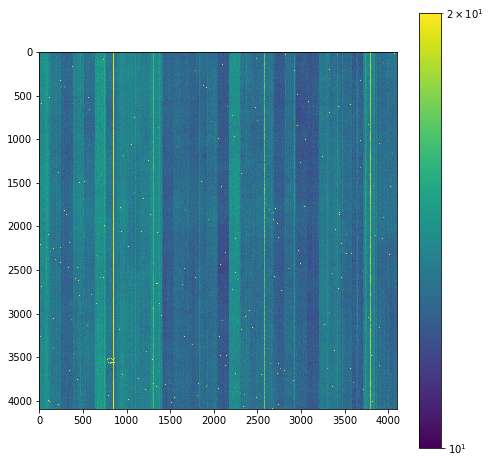

In [76]:
plt.imshow(np.sqrt(var), vmin=10.,vmax=20., norm=colors.LogNorm())
plt.colorbar()

In [69]:
print(pt)

/projects/HSC/PFS/JHU/ramps/2021-08-24/PFJB02402223.fits


(array([ 2.,  3.,  6., 10.,  4.,  0.,  4.,  4.,  2.,  1.]),
 array([16.366184, 16.833689, 17.301191, 17.768696, 18.236198, 18.703703,
        19.171207, 19.63871 , 20.106215, 20.573717, 21.041222],
       dtype=float32),
 <a list of 10 Patch objects>)

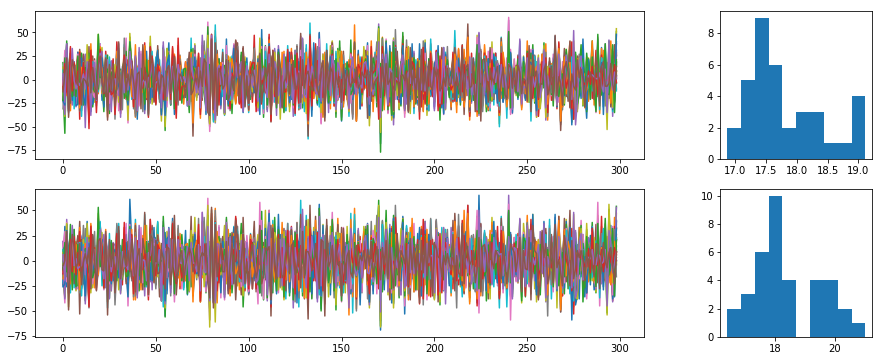

In [10]:
fig, axarr = plt.subplots(2,2,figsize=(15,6), gridspec_kw={'width_ratios':[4,1]})

steps = np.arange(0, 4096, 4096//5)
rvar = []
dvar = []
for ydx in steps:
    for xdx in steps:
        pixel = ref[:,ydx,xdx]
        axarr[0,0].plot(pixel[1:] - pixel[:-1])#, color='k', alpha=0.3)
        rvar.append(np.std(pixel[1:] - pixel[:-1]))
        
        pixel = data[:,ydx,xdx]
        axarr[1,0].plot ( pixel[1:] - pixel[:-1])
        dvar.append(np.std(pixel[1:] - pixel[:-1]))
        
axarr[0,1].hist(rvar)
axarr[1,1].hist(dvar)

In [128]:
refvar = np.std(utr,axis=0)

In [129]:
refvar.mean()

17.671198

In [94]:
nosubvar = np.var(ref-ref[0],axis=0)

In [104]:
from_data = np.var ( stack[1:] - stack[:-1], axis=0 )

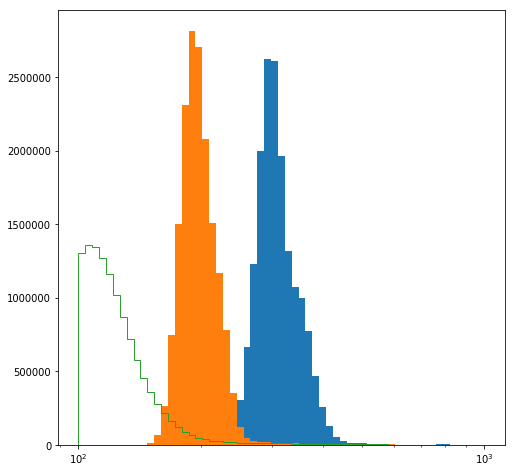

In [105]:
bins=np.logspace (2,3,60)
plt.hist ( refvar.flatten (), bins=bins )
plt.hist ( nosubvar.flatten (), bins=bins )
plt.hist ( from_data.flatten (), bins=bins, histtype='step' )
plt.xscale('log')

In [91]:
hdr = fits.getheader(pt, 0)